# Project 5: Vehicle Detection

## 1 Import all needed libraries

In [58]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
import math
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from skimage.feature import hog
%matplotlib inline

## 2 Load car and non-car images sets

In [15]:
# loading raw car images
car_extracted = glob.glob('vehicles/KITTI_extracted/*.png')
car_right = glob.glob('vehicles/GTI_Right/image*.png')
car_middle_close = glob.glob('vehicles/GTI_MiddleClose/image*.png')
car_far = glob.glob('vehicles/GTI_Far/image*.png')
car_left = glob.glob('vehicles/GTI_Left/image*.png')
# loading raw non car images
non_car_gti = glob.glob('non-vehicles/GTI/image*.png')
non_car_extras = glob.glob('non-vehicles/Extras/extra*.png')

# combile all car sets together
cars = car_far + car_left + car_right + car_middle_close + car_extracted
# combile all non car sets together
non_cars = non_car_gti + non_car_extras

# shuffling the car raw images
shuffle(cars)
# shuffling the raw non car images
shuffle(non_cars)

['non-vehicles/Extras/extra5688.png',
 'non-vehicles/Extras/extra4603.png',
 'non-vehicles/Extras/extra1820.png',
 'non-vehicles/GTI/image2161.png',
 'non-vehicles/Extras/extra2024.png',
 'non-vehicles/Extras/extra2568.png',
 'non-vehicles/GTI/image581.png',
 'non-vehicles/GTI/image1671.png',
 'non-vehicles/GTI/image2011.png',
 'non-vehicles/Extras/extra3528.png',
 'non-vehicles/GTI/image1348.png',
 'non-vehicles/Extras/extra5365.png',
 'non-vehicles/Extras/extra1527.png',
 'non-vehicles/GTI/image2088.png',
 'non-vehicles/Extras/extra152.png',
 'non-vehicles/Extras/extra1718.png',
 'non-vehicles/GTI/image762.png',
 'non-vehicles/Extras/extra3305.png',
 'non-vehicles/Extras/extra1872.png',
 'non-vehicles/Extras/extra2569.png',
 'non-vehicles/Extras/extra1796.png',
 'non-vehicles/GTI/image822.png',
 'non-vehicles/Extras/extra1258.png',
 'non-vehicles/Extras/extra4641.png',
 'non-vehicles/GTI/image679.png',
 'non-vehicles/Extras/extra810.png',
 'non-vehicles/Extras/extra5380.png',
 'non-v

In [16]:
print("len(cars):", len(cars))

print("len(non_cars):", len(non_cars))

len(cars): 8792
len(non_cars): 8968


# 3 Display some sample pics (car and non-car)

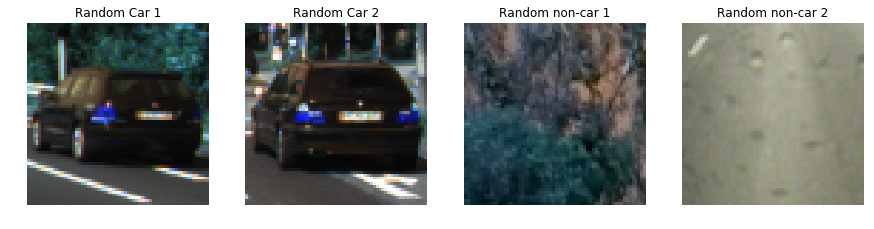

In [20]:
car_index1 = np.random.randint(0, len(cars))
car_index2 = np.random.randint(0, len(cars))
non_car_index1 = np.random.randint(0, len(non_cars))
non_car_index2 = np.random.randint(0, len(non_cars))

car_image1 = cv2.imread(cars[car_index1])
car_image2 = cv2.imread(cars[car_index2])
non_car_image1 = cv2.imread(non_cars[non_car_index1])
non_car_image2 = cv2.imread(non_cars[non_car_index2])

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('Random Car 1')
axs[0].imshow(car_image1)

axs[1].axis('off')
axs[1].set_title('Random Car 2')
axs[1].imshow(car_image2)

axs[2].axis('off')
axs[2].set_title('Random non-car 1')
axs[2].imshow(non_car_image1)

axs[3].axis('off')
axs[3].set_title('Random non-car 2')
axs[3].imshow(non_car_image2)


## 4 Color Histogram Feature Extraction

In [39]:
# Define a function to compute color histogram features
# Use the code from course(Histogram of color section)

def color_hist(img, num_bins = 32, bin_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=num_bins, range=bin_range)
    ghist = np.histogram(img[:,:,1], bins=num_bins, range=bin_range)
    bhist = np.histogram(img[:,:,2], bins=num_bins, range=bin_range)
    
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0 : len(bin_edges) - 1]) / 2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

In [35]:
# red histogram
r_hist = np.histogram(car_image1[:,:,0])

In [36]:
# contains the counts in each of the bins
r_hist[0]

array([1556, 1037,  916,  232,   98,   93,   45,   33,   37,   49])

In [37]:
# contains the bin edges (so it is one element longer than r_hist[0]).
r_hist[1]

array([   2. ,   27.3,   52.6,   77.9,  103.2,  128.5,  153.8,  179.1,
        204.4,  229.7,  255. ])

In [42]:
rh, gh, bh, bincen, feature_vec = color_hist(car_image1, num_bins=32, bin_range =(0, 256))

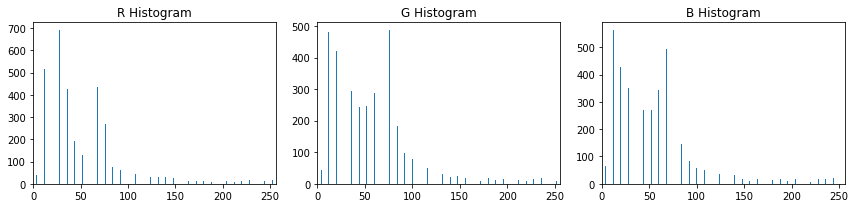

In [45]:
# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12, 3))
    
    plt.subplot(131)
    plt.bar(bincen, rh[0]) # plt.bar(x, y)
    plt.xlim(0, 256)
    plt.title('R Histogram')
    
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

## 5 Explore the color space

In [85]:
# Use the code from course(section: Explore color space)

from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), 
           axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(6, 6))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=7, pad=4)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

In [113]:
def plot_image_color_space(img):

    # Select a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

    # Convert subsampled image to desired color space(s)
    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
    img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
    img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
    img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)
    img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
    img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting
    
    # Plot and show
    plot3d(img_small_RGB, img_small_rgb, axis_labels=list("RGB"))
    plt.show()

    plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
    plt.show()
    
    plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
    plt.show()
    
    plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
    plt.show()

    plot3d(img_small_YUV, img_small_rgb, axis_labels=list("YUV"))
    plt.show()
    
    plot3d(img_small_YCrCb, img_small_rgb, axis_labels=list("YCrCb"))
    plt.show()

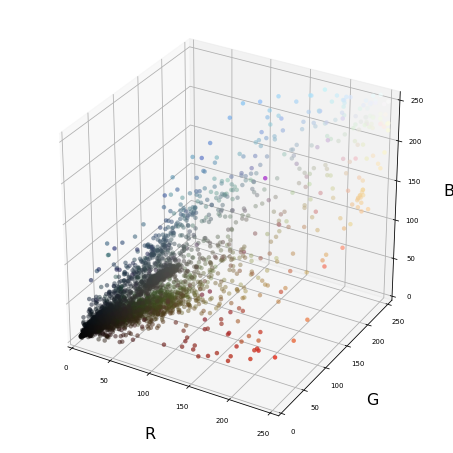

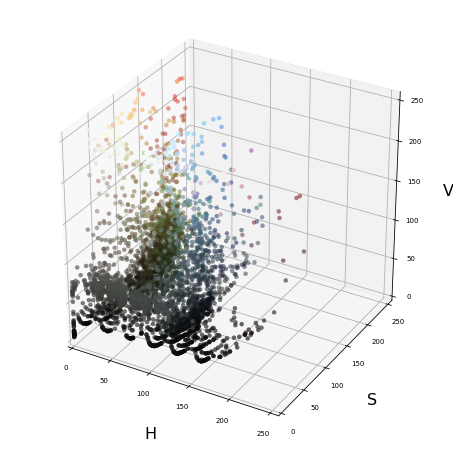

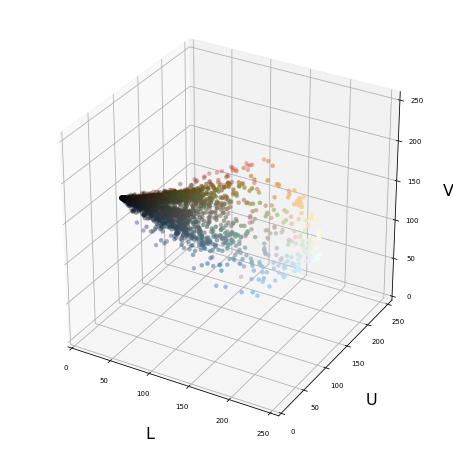

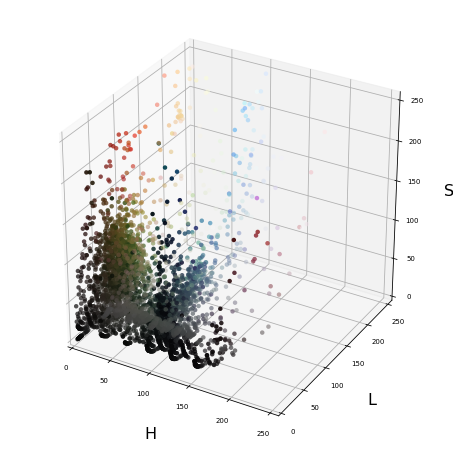

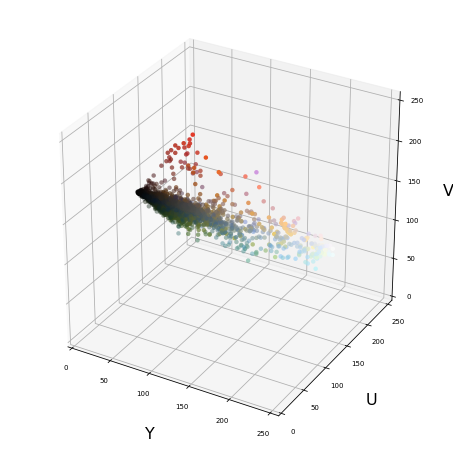

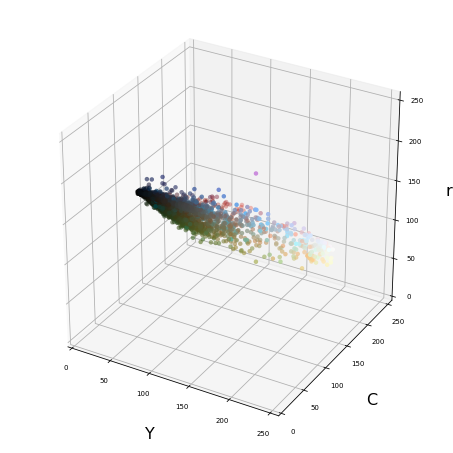

In [114]:
# Read a color car image
plot_image_color_space(car_image1)

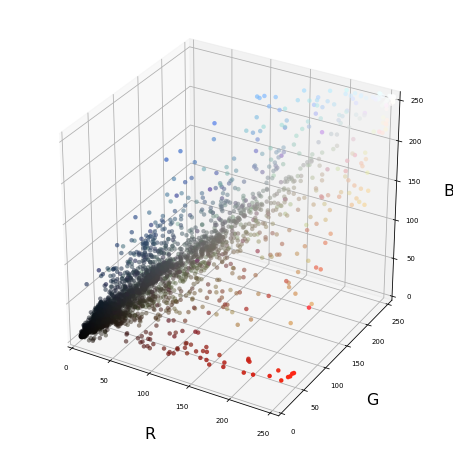

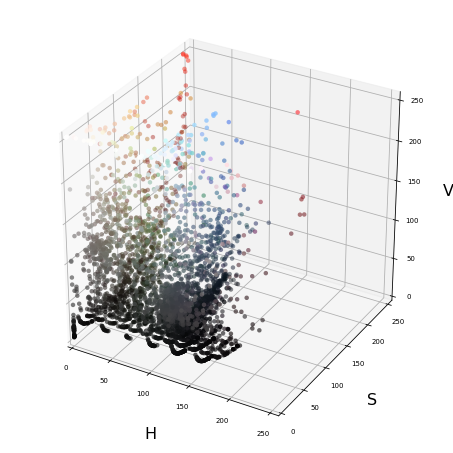

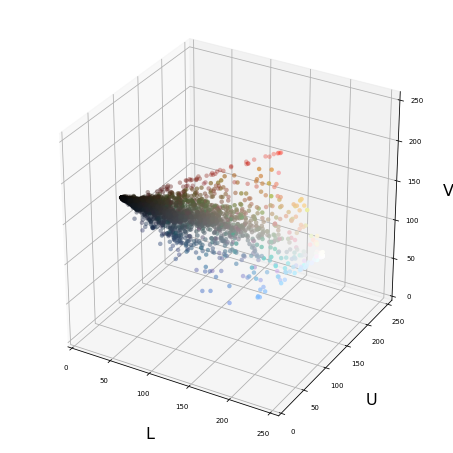

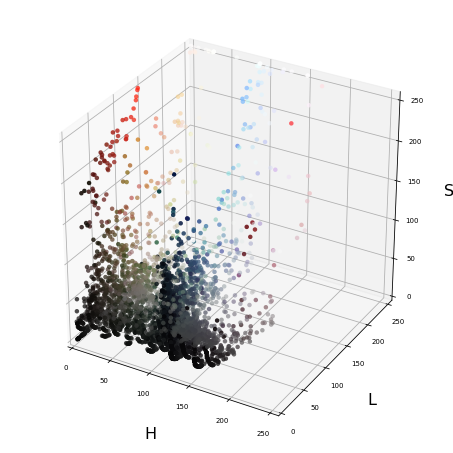

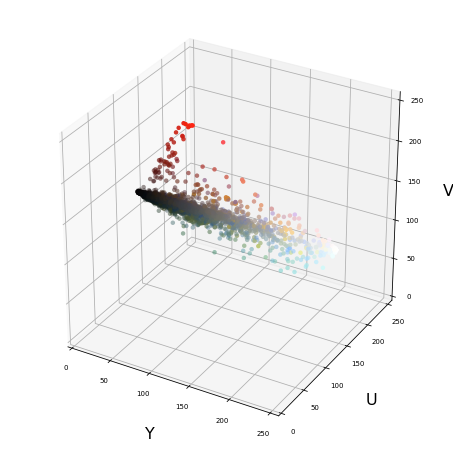

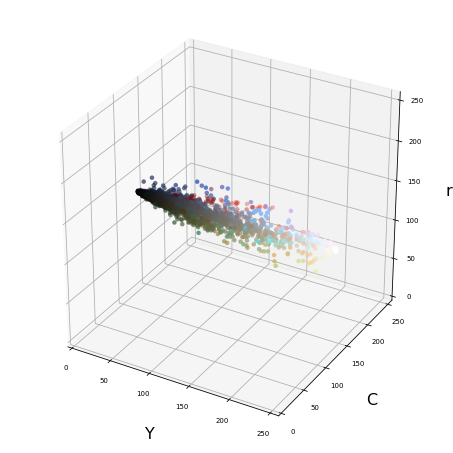

In [115]:
# Read a color car image
plot_image_color_space(car_image2)

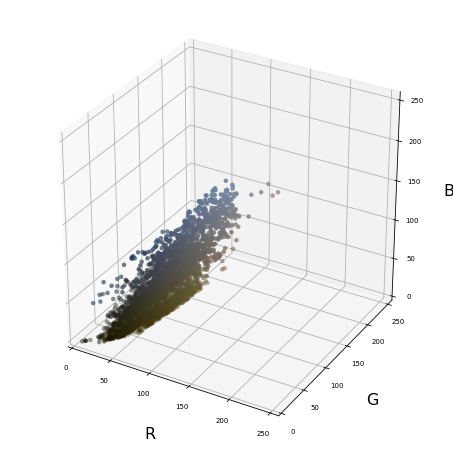

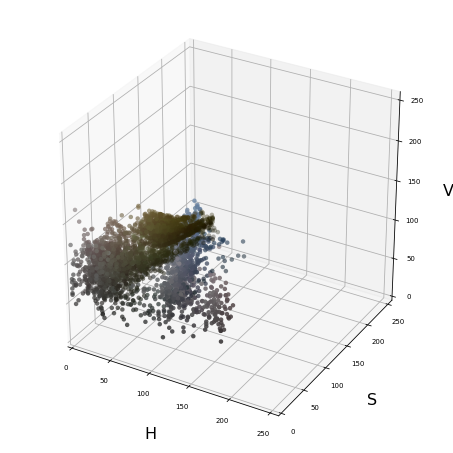

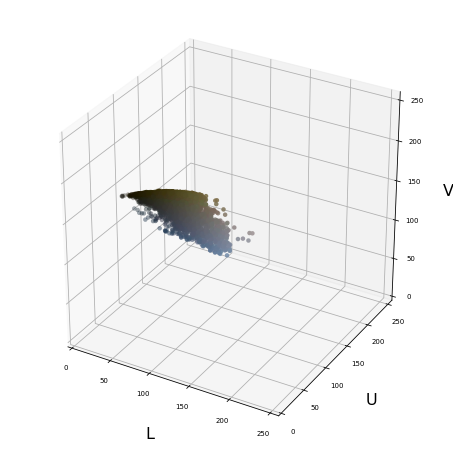

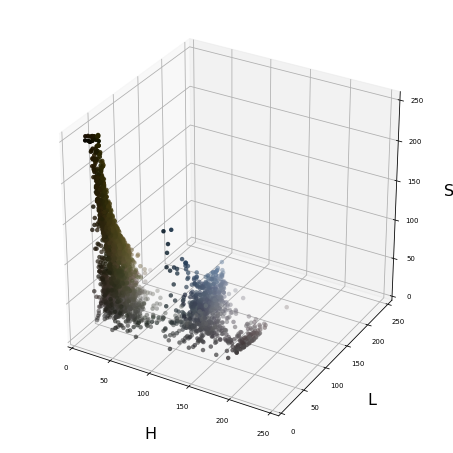

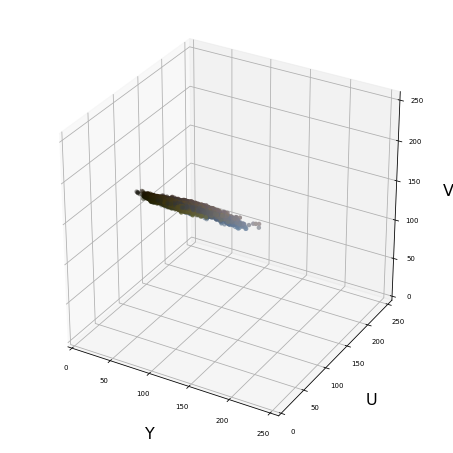

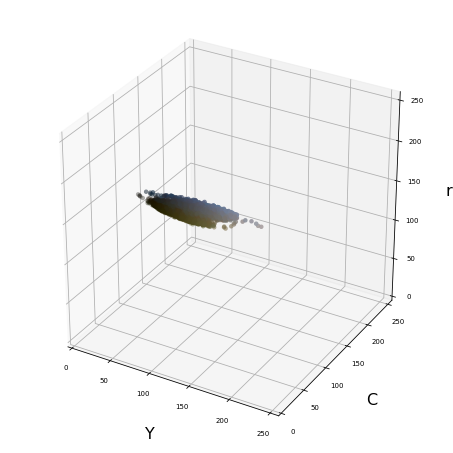

In [116]:
# Read a color non car image
plot_image_color_space(non_car_image1)

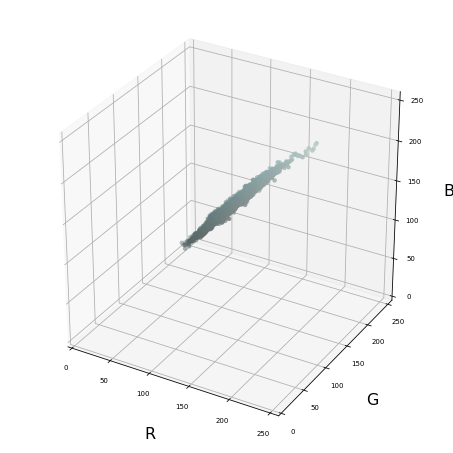

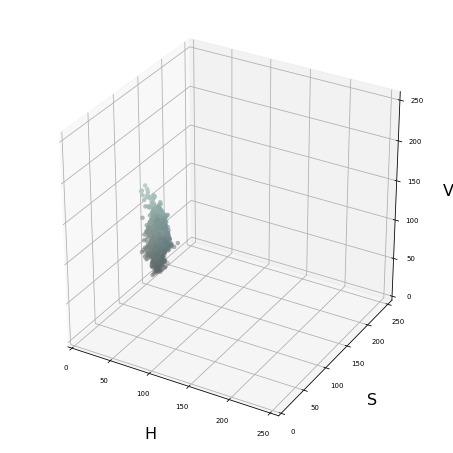

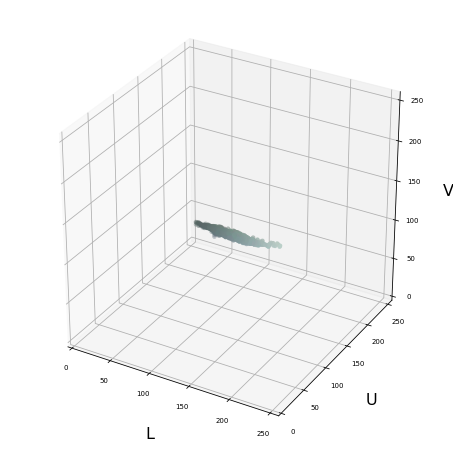

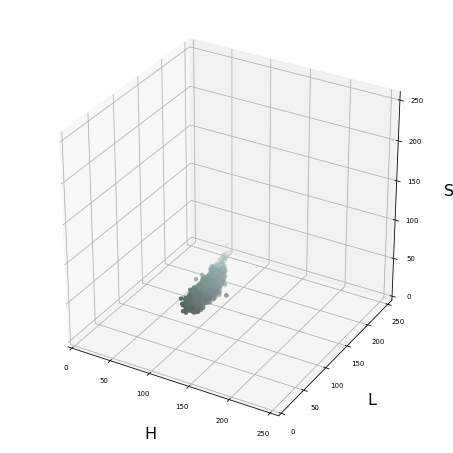

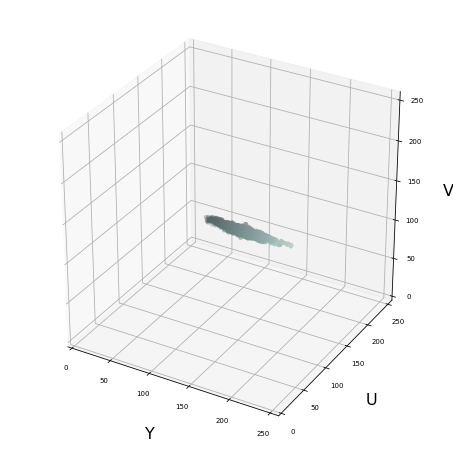

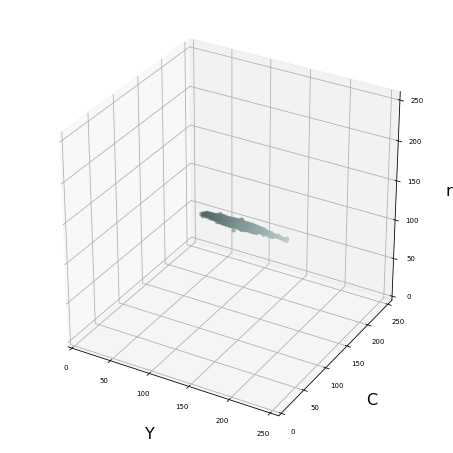

In [117]:
# Read a color non car image
plot_image_color_space(non_car_image2)

### We can notice that there are some different between car and non-car images

# 6 Spatial Binning of Color

In [106]:
# Use the code piece from course(Section: Spatial Binning of Color)
# Define a function to compute binned color features  
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [157]:
def plot_image_bin_spatial(img):
    
    feature_vec_ycrcb = bin_spatial(img, color_space='YCrCb', size=(32, 32))
    feature_vec_rgb = bin_spatial(img, color_space='RGB', size=(32, 32))    
    feature_vec_hsv = bin_spatial(img, color_space='HSV', size=(32, 32))
    feature_vec_luv = bin_spatial(img, color_space='LUV', size=(32, 32))
    feature_vec_hls = bin_spatial(img, color_space='HLS', size=(32, 32))
    feature_vec_yuv = bin_spatial(img, color_space='YUV', size=(32, 32))
    
    
    #fig = plt.figure(figsize=(12, 6))
    f, axarr = plt.subplots(2, 3, figsize=(10,5))
    
    #plt.subplot(131)
    axarr[0, 0].plot(feature_vec_ycrcb)
    axarr[0, 0].set_title('YCrCb')
    
    #plt.subplot(132)
    axarr[0, 1].plot(feature_vec_rgb)
    axarr[0, 1].set_title('RGB')

    #plt.subplot(133)
    axarr[0, 2].plot(feature_vec_hsv)
    axarr[0, 2].set_title('HSV')
    
    #plt.subplot(231)
    axarr[1, 0].plot(feature_vec_luv)
    axarr[1, 0].set_title('LUV')
    
    #plt.subplot(232)
    axarr[1, 1].plot(feature_vec_hls)
    axarr[1, 1].set_title('HLS')
    
    #plt.subplot(233)
    axarr[1, 2].plot(feature_vec_yuv)
    axarr[1, 2].set_title('YUV')
    
    f.subplots_adjust(hspace=1, wspace=1)


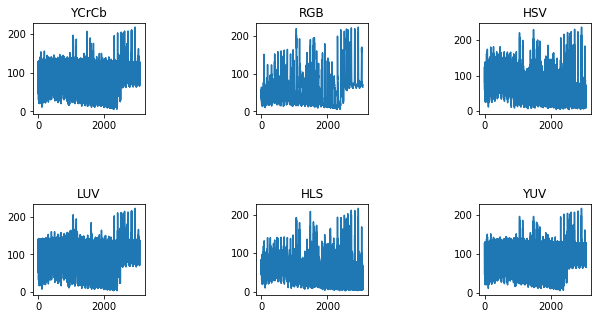

In [169]:
plot_image_bin_spatial(car_image1)

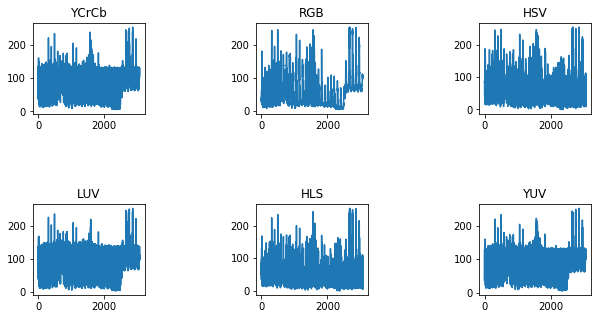

In [170]:
plot_image_bin_spatial(car_image2)

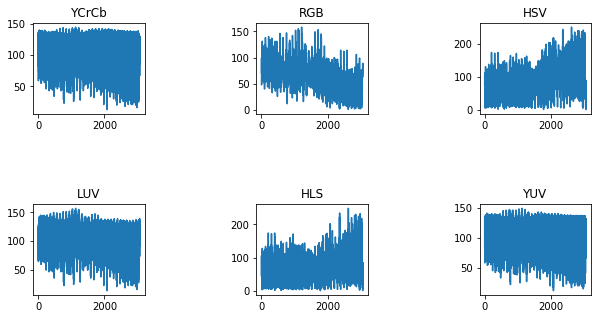

In [171]:
plot_image_bin_spatial(non_car_image1)

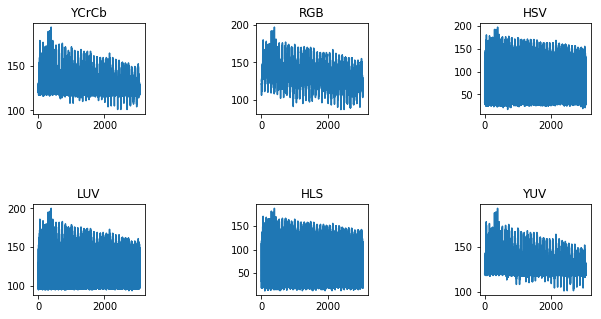

In [172]:
plot_image_bin_spatial(non_car_image2)

# 7 Histogram of Oriented Gradient (HOG) Feature Extraction

In [269]:
# Use the code from course(Section: scikit-image HOG)
# Define a function to return HOG features and visualization
def get_hog_features(img, 
                     orientations, 
                     pixels_per_cell, 
                     cells_per_block, 
                     vis=False, 
                     feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, 
                                  orientations = orientations, 
                                  pixels_per_cell = (pixels_per_cell, pixels_per_cell),
                                  cells_per_block = (cells_per_block, cells_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, 
                                  feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                       cells_per_block=(cells_per_block, cells_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation:

Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15



HOG features.shape:  (3, 3, 2, 2, 32)
After ravel(), feature vector:  (1152,)


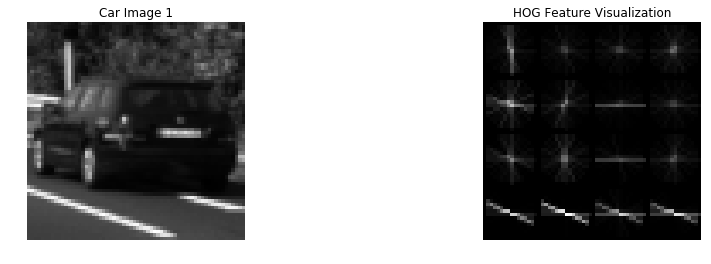

In [175]:
car_image1_gray = cv2.cvtColor(car_image1, cv2.COLOR_RGB2GRAY)
orientations = 32
pixels_per_cell = 16
cells_per_block = 2

# extract HOG feature and get a hog images for visualization
features, hog_image = get_hog_features(car_image1_gray, orientations, pixels_per_cell, cells_per_block, vis=True, feature_vec=False)

hog_vector = np.ravel(features)
print('HOG features.shape: ', features.shape)
print('After ravel(), feature vector: ', hog_vector.shape)

# Plot the examples
fig, ax = plt.subplots(1,2, figsize=(15, 4))
ax = ax.ravel()

ax[0].axis('off')
ax[0].set_title('Car Image 1')
ax[0].imshow(car_image1_gray, cmap='gray')

ax[1].axis('off')
ax[1].set_title('HOG Feature Visualization')
ax[1].imshow(hog_image, cmap='gray')

# 8 Combine and Normalize Features

## Combine Spatial & Color & HOG features

In [182]:
# Use code base from course(section: Combine and Normalize Features) and add HOG Feature extraction (from section: HOG Classify)
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist() and get_hog_features()
def extract_features(imgs, 
                     color_space='RGB', 
                     spatial_size=(32, 32),
                     hist_bins=32, 
                     orientations=16, 
                     pixels_per_cell=16, 
                     cells_per_block=2, 
                     hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        spatial_features = bin_spatial(feature_image, size=spatial_size)
        rh, gh, bh, bincen, hist_features = color_hist(feature_image, num_bins=32, bin_range =(0, 256))

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                     orientations, 
                                                     pixels_per_cell, 
                                                     cells_per_block, 
                                                     vis=False, 
                                                     feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                            orientations, 
                                            pixels_per_cell, 
                                            cells_per_block, 
                                            vis=False, 
                                            feature_vec=True)
        
        # Combile all feature together
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    
    # Return list of feature vectors
    return features

In [186]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orientations = 32
pixels_per_cell = 16
cells_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins = 32

car_features = extract_features(cars, 
                                color_space, 
                                spatial_size, 
                                hist_bins, 
                                orientations, 
                                pixels_per_cell, 
                                cells_per_block,
                                hog_channel)

non_car_features = extract_features(non_cars, 
                                    color_space, 
                                    spatial_size,
                                    hist_bins, 
                                    orientations, 
                                    pixels_per_cell, 
                                    cells_per_block,
                                    hog_channel)

/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation:

Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15



## Normalize combined features and visualization on them

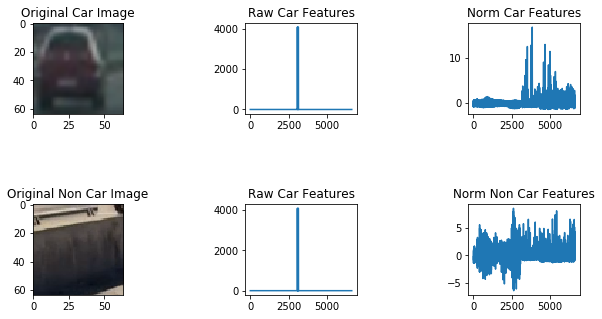

In [205]:
# Use code from course(section: Combine and Normalize Features)

# Create an array stack of feature vectors
X = np.vstack((car_features, non_car_features)).astype(np.float64)  

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

car_ind = np.random.randint(0, len(cars))
non_car_ind = np.random.randint(0, len(non_cars))

f, axarr = plt.subplots(2, 3, figsize=(10,5))

#plt.subplot(131)
axarr[0, 0].imshow(mpimg.imread(cars[car_ind]))
axarr[0, 0].set_title('Original Car Image')

#plt.subplot(132)
axarr[0, 1].plot(X[car_ind])
axarr[0, 1].set_title('Raw Car Features')

#plt.subplot(133)
axarr[0, 2].plot(scaled_X[car_ind])
axarr[0, 2].set_title('Norm Car Features')

#plt.subplot(231)
axarr[1, 0].imshow(mpimg.imread(non_cars[non_car_ind]))
axarr[1, 0].set_title('Original Non Car Image')

#plt.subplot(232)
axarr[1, 1].plot(X[non_car_ind])
axarr[1, 1].set_title('Raw Car Features')

#plt.subplot(233)
axarr[1, 2].plot(scaled_X[non_car_ind])
axarr[1, 2].set_title('Norm Non Car Features')

f.subplots_adjust(hspace=1, wspace=1)


# 9 Prepare training data and test data set and train a Car classifier

In [215]:
# Use code base from course(Section: HOG Classify & Color Classify)

# we give 1 to car set, and 0 to non car set, generate ground truth of training data
y = np.hstack((np.ones(len(car_features)), 
               np.zeros(len(non_car_features))))


# Split the data set into training set and testting set with 8:2 ratio
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state = rand_state)
# Use LinearSVC as our classifier model
svc = LinearSVC()
# Check the training time for the SVC
begin_time = time.time()
# Train the SVC
svc.fit(X_train, y_train)
end_time = time.time()
print('We use ', round(end_time - begin_time, 3), 'seconds training the model')

# Use Test set to test the model
print('With test set, the model score is = ', round(svc.score(X_test, y_test), 5))

# Check the prediction time for a single sample
begin_time = time.time()
n_predict = 10
print('The 10 prediction from the Model: ', svc.predict(X_test[0 : n_predict]))
print('The Ground Truth labels         : ', y_test[0:n_predict])
end_time = time.time()
print(round(end_time - begin_time, 5), 'Seconds to predict', n_predict,'labels with SVC')

We use  14.17 seconds training the model
With test set, the model score is =  0.9893
The 10 prediction from the Model:  [ 0.  0.  0.  1.  0.  1.  1.  1.  0.  0.]
The Ground Truth labels         :  [ 0.  0.  0.  1.  0.  1.  1.  1.  0.  0.]
0.00192 Seconds to predict 10 labels with SVC


# 10 Use Sliding Windows Technique To Find Car!

## Draw boxes on a given image

In [258]:
# Draw boxes on the image, 
# Use code from course(Section: Sliding Window Implementation)

def draw_boxes(img, bboxes, color=(0, 0, 255), thick = 7):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)

    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

## Implementation of Sliding Window

In [250]:
# Use code from Section: Sliding Window Implementation)

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# then return a list of windows which need to be calculated feature on it
def slide_window(img, 
                 x_start_stop=[None, None], 
                 y_start_stop=[None, None], 
                 xy_window=(64, 64), 
                 xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list

In [278]:
# Code from course(section Search and Classify)

# extract features for a single image
def single_img_features(img, 
                        color_space = 'RGB', 
                        spatial_size = (32, 32),
                        hist_bins = 32, 
                        orientations = 32, 
                        pixels_per_cell = 16, 
                        cells_per_block =2, 
                        hog_channel ='ALL'):
    
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
        
    #3) Compute spatial features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    
    #4) Append features to list
    img_features.append(spatial_features)
        
    #5) Compute histogram features
    rh, gh,bh, bincen, hist_features = color_hist(feature_image, num_bins=hist_bins)
    
    #6) Append features to list
    img_features.append(hist_features)
        
    #7) Compute HOG features
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                                 orientations, 
                                                 pixels_per_cell, 
                                                 cells_per_block, 
                                                 vis=False, 
                                                 feature_vec=True))      
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                        orientations, 
                                        pixels_per_cell, 
                                        cells_per_block, 
                                        vis=False, 
                                        feature_vec=True)
    
    #8) Append features to list
    img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [279]:
# Code from course(section Search and Classify)

# This function will receive a image  
# and a list of windows (output of slide_windows()) to be searched,
# then return windows for positive detection.

def search_windows(img, 
                   windows, 
                   clf, 
                   scaler, 
                   color_space = 'RGB', 
                   spatial_size = (32, 32), 
                   hist_bins = 32, 
                   hist_range = (0, 256), 
                   orientations = 32, 
                   pixels_per_cell = 16, 
                   cells_per_block = 2, 
                   hog_channel = 'ALL'):
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, 
                                       color_space = color_space, 
                                       spatial_size = spatial_size, 
                                       hist_bins = hist_bins, 
                                       orientations = orientations, 
                                       pixels_per_cell = pixels_per_cell, 
                                       cells_per_block = cells_per_block, 
                                       hog_channel = hog_channel)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    #8) Return windows for positive detections
    return on_windows

In [289]:
# Hog Sub-sampling Window Search(Code from course)
# Didn't use it for prediction
# Will try in future

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orientations, pixels_per_cell, cells_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pixels_per_cell) - cells_per_block + 1
    nyblocks = (ch1.shape[0] // pixels_per_cell) - cells_per_block + 1 
    nfeat_per_block = orientations * cells_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pixels_per_cell) - cells_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orientations, pixels_per_cell, cells_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orientations, pixels_per_cell, cells_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orientations, pixels_per_cell, cells_per_block, feature_vec = False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pixels_per_cell
            ytop = ypos*pixels_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, num_bins = hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [281]:
# ystart = 400
# ystop = 656
# scale = 1.5

# img = mpimg.imread('test_images/test1.jpg')
    
# out_img = find_cars(img, 
#                     ystart, 
#                     ystop, 
#                     scale, 
#                     svc, 
#                     X_scaler, 
#                     orientations, 
#                     pixels_per_cell, 
#                     cells_per_block, 
#                     spatial_size, 
#                     hist_bins)

# plt.imshow(out_img)

In [291]:
def get_hot_boxes (image):
    # Here we define 3 type of search schema with different searching area and step and overlap ratio.
    window_x_limits = [[None, None],
                       [40, None],
                       [400, 1280]]

    window_y_limits = [[380, 640],
                       [400, 600],
                       [440, 560]]

    window_size = [(128, 128),
                   (96, 96),
                   (64, 64)]

    window_overlap_ratio = [(0.6, 0.6),
                            (0.7, 0.7),
                            (0.8, 0.8)]
    
    draw_image = np.copy (image)
    all_hot_windows = []
    
    # iterate over previousely defined sliding windows
    for x_limits, y_limits, window_size_dst, overlap in zip (window_x_limits, 
                                                             window_y_limits, 
                                                             window_size, 
                                                             window_overlap_ratio):
        windows = slide_window(
            draw_image,
            x_start_stop = x_limits,
            y_start_stop = y_limits, 
            xy_window = window_size_dst,
            xy_overlap = overlap
        )
        hot_windows = search_windows(draw_image, 
                                     windows, 
                                     svc, 
                                     X_scaler, 
                                     color_space = color_space, 
                                     spatial_size = spatial_size, 
                                     hist_bins = hist_bins,
                                     hist_range = (0,256),
                                     orientations = orientations, 
                                     pixels_per_cell = pixels_per_cell, 
                                     cells_per_block= 2, 
                                     hog_channel= 'ALL')                          
        
        all_hot_windows.extend(hot_windows)
        
        img_1windowsize = draw_boxes(draw_image, hot_windows, color = (0, 0, 1), thick = 4)
        
    img_allwindowsize = draw_boxes(draw_image, all_hot_windows, color = (0, 0, 1),thick = 4)
    
    return all_hot_windows, img_1windowsize, img_allwindowsize

Hyper parameters and feature length: 
orientations:  32
pixels_per_cell:  16
cells_per_block:  2
feature vector length:  6624


/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation:

Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15



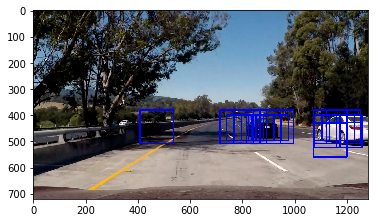

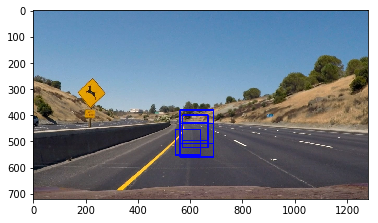

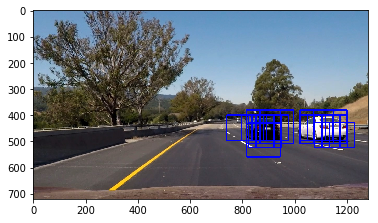

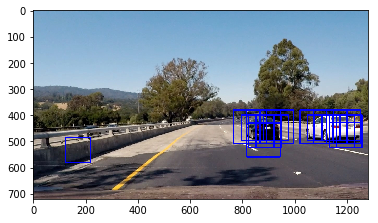

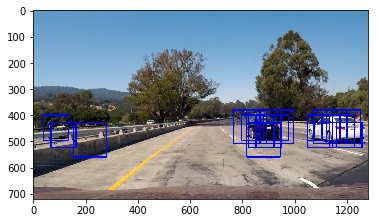

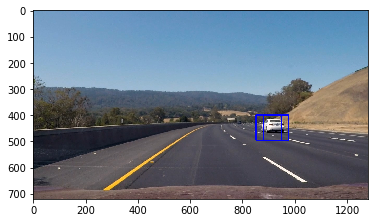

In [292]:
print('Hyper parameters and feature length: ')
print('orientations: ', orientations)
print('pixels_per_cell: ', pixels_per_cell)
print('cells_per_block: ', cells_per_block)
print('feature vector length: ', len(X_train[0]))

for image_test in glob.glob('test_images/test*.jpg'):
    # load test image:
    test_image = mpimg.imread(image_test)
    
    # normalize data
    test_image_n = test_image.astype(np.float32) / 255
                
    hot_window, img_singlewindow, img_allwindow = get_hot_boxes(test_image_n)

    plt.figure()
    plt.imshow(img_allwindow)

# 11 Using heatmap to do Multiple Detections & False Positives

In [293]:
# Code from course(section: Multiple Detections & False Positives)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

/home/willwywang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation:

Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15



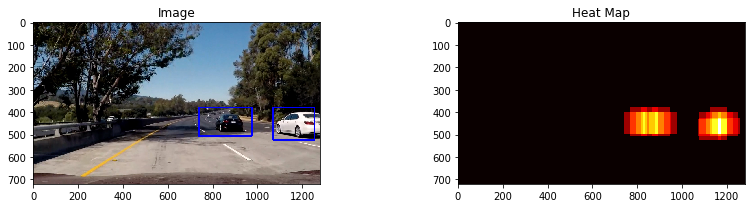

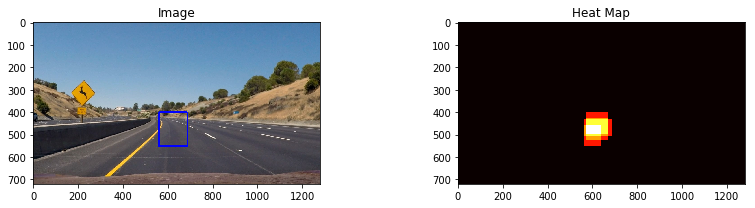

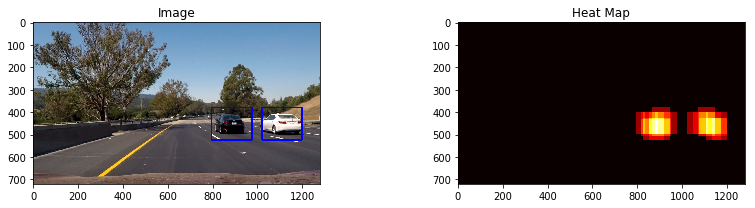

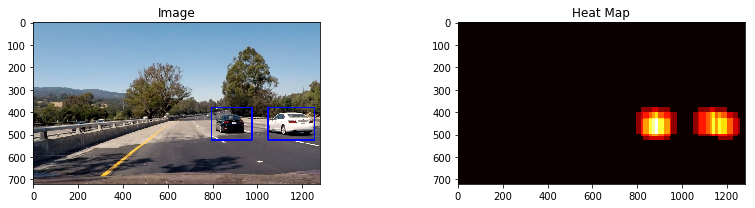

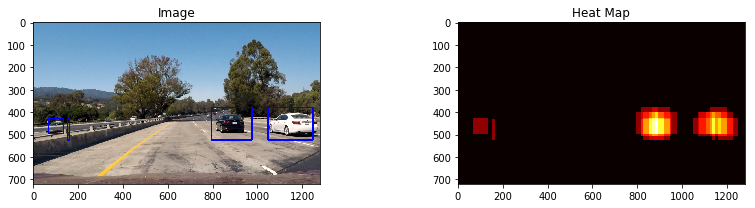

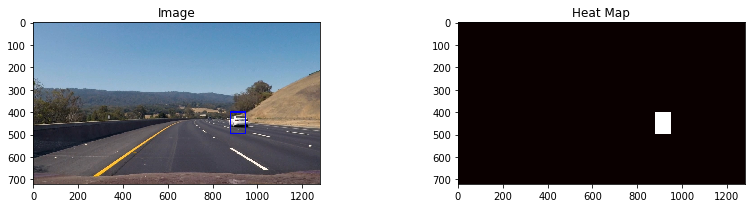

In [294]:
# Use code base from course(section: Multiple Detections & False Positives)

heatmap_combined = np.zeros_like(img_allwindow[:,:,0]).astype(np.float)

for image_test in glob.glob('test_images/test*.jpg'):
    # load test image
    test_image = mpimg.imread(image_test)
    
    # make a clone
    draw_image = np.copy(test_image)
    
    # normalize
    draw_image_norm = draw_image.astype(np.float32)/255
    
    hot_window = []
    
    hot_window, img_singlewindow, img_allwindow = get_hot_boxes(draw_image_norm)

    # Add heat to each box in box list
    heat_img = np.zeros_like(draw_image[:,:,0]).astype(np.float)
    heat = add_heat(heat_img, hot_window)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    heatmap_combined = heatmap_combined + heatmap

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(np.copy(test_image), labels)

    fig = plt.figure(figsize=(12,3))
    plt.subplot(121)
    plt.imshow(draw_image)
    plt.title('Image')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    
    fig.tight_layout()

# 12 Define a function to process each frame from video

In [298]:
global extended_heatmap
global total_heatmap
global frame_index

def process_frame(img):  
    frame_index = 0
    extended_heatmap = []
    
    # Initialzation
    total_heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Normalization
    test_image_norm = img.astype(np.float32) / 255
    
    # Get all hot windows
    hot_window = []
    hot_window, img_singlewindow, img_allwindow = get_hot_boxes(test_image_norm)

    # Add heat to each box in box list
    heat_img = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat_img, hot_window)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # add current heat map to overall heap map for 10 frames
    if (frame_index < 10):
        extended_heatmap.append(heatmap) 
        frame_index += 1
        total_heatmap = heatmap
    else:
        extended_heatmap.pop(0)
        extended_heatmap.append(heatmap)
        total_heatmap -= heatmap[0]
        total_heatmap += heatmap[9]
        
    # Find final boxes from heatmap using label function
    total_heatmap = apply_threshold(total_heatmap,1)
    labels = label(total_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

# 13 Processing the video

In [299]:
# Libaries for video 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video = 'vehicle_detected_test.mp4'
clip1 = VideoFileClip("test_video.mp4")#.subclip(20,30)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video vehicle_detected_test.mp4
[MoviePy] Writing video vehicle_detected_test.mp4


 97%|█████████▋| 38/39 [01:19<00:02,  2.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_detected_test.mp4 

CPU times: user 1min 19s, sys: 0 ns, total: 1min 19s
Wall time: 1min 19s


In [300]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [ ]:
output_video2 = 'vehicle_detected.mp4'
clip2 = VideoFileClip("project_video.mp4")#.subclip(20,30)
white_clip2 = clip2.fl_image(process_frame)
%time white_clip2.write_videofile(output_video2, audio=False)

[MoviePy] >>>> Building video vehicle_detected.mp4
[MoviePy] Writing video vehicle_detected.mp4


 15%|█▍        | 183/1261 [06:11<36:43,  2.04s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video2))